### E27 Medical U-Net

- 학습 목표
    - 위내시경 이미지에 용종을 표시한 데이터를 이용해 모델을 구성하고, 용종을 찾는 Segmentation 모델을 만들어 본다. 
    - 의료이미지 특성상 수가 적은 데이터셋을 활용하기 위한 Data augmentation을 진행해 본다. 
    - Encoder-Decoder Model과 U-Net 모델을 구현해 보고, U-Net이 일반 Encoder-Decoder 모델 대비 어느정도 성능향상이 되는지 확인해 본다. 
    - U-Net에 pretrained encode를 적용하여 성능개선을 확인해 본다.

In [1]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12, 12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models


2.3.1


#### 1. 데이터 수집 및 Visualization
##### 1.1 데이터 수집

In [2]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel/medical')

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)
    
import urllib.request
u = urllib.request.urlopen(url='https://aiffelstaticprd.blob.core.windows.net/media/documents/sd_train.zip')
data = u.read()
u.close()

with open('sd_train.zip', 'wb') as f:
    f.write(data)
    print('Data has been downloaded')
    
shutil.move(os.path.join('sd_train.zip'), os.path.join(DATASET_PATH))
file_path = os.path.join(DATASET_PATH, 'sd_train.zip')

import zipfile
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(DATASET_PATH)
zip_ref.close()
print('Data has been extracted.')

Data has been downloaded
Data has been extracted.


##### 1.2 Split dataset into train data and test data

In [3]:
img_dir = os.path.join(DATASET_PATH, 'train')
label_dir = os.path.join(DATASET_PATH, 'train_labels')

In [4]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [6]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print(f"Number of training examples: {num_train_examples}")
print(f"Number of test examples: {num_test_examples}")


Number of training examples: 480
Number of test examples: 120


##### 1.3 Visualization

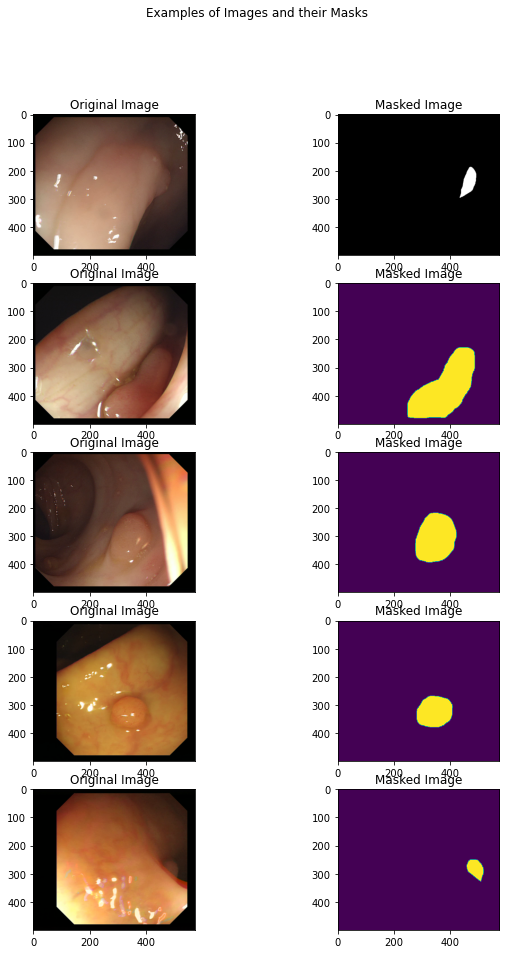

In [7]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2,2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]
    
    plt.subplot(display_num, 2, i+1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")
    
    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)
    
    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [8]:
# hyperparameter

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 50

#### 2. Data pipeline and Preprocessing

In [9]:
def _process_pathnames(fname, label_path):
    
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)
    
    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=1)
    
    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)
    
    scale = 1 / 255.
    img = tf.cast(img, dtype = tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    
    return img, label_img

In [10]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([], -width_shift_range * img_shape[0], width_shift_range * img_shape[0])
            
        if height_shift_range:
            height_shift_range = tf.random.uniform([], -height_shift_range * img_shape[0], height_shift_range * img_shape[0])
            
        output_img = tfa.image.translate(output_img, [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img, [width_shift_range, height_shift_range])
        
        return output_img, label_img

In [11]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5), lambda: (tf.image.flip_left_right(tr_img,), tf.image.flip_left_right(label_img)), lambda: (tr_img, label_img))
        
        return tr_img, label_img

In [12]:
def _augment(img, label_img, resize=None, scale=1, hue_delta=0., horizontal_flip=True, width_shift_range=0.05, height_shift_range=0.05):
    
    if resize is not None:
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
        
    if hue_delta:
        img = tf.image.random_hue(img, hud_delta)
        
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    
    return img, label_img

In [13]:
def get_baseline_dataset(filenames, labels, preproc_fn=functools.partial(_augment), threads=4, batch_size=batch_size, is_train=True):
    
    num_x = len(filenames)
    
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    
    if is_train:
        
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)
        
    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames)
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames, y_test_filenames, is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

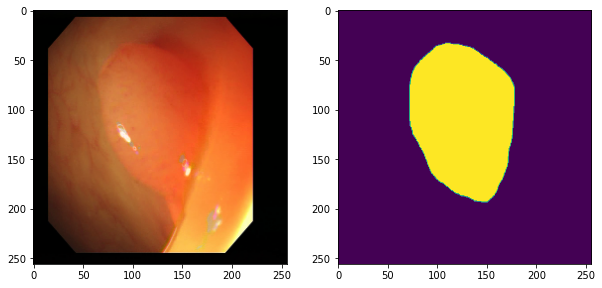

In [15]:
for images, labels in train_dataset.take(1):
    
    plt.figure(figsize=(10, 10))
    img = images[0]
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    
    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

#### 3. 모델 구현
- Encoder-Decoder

In [16]:
encoder = tf.keras.Sequential(name='encoder')

encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))

In [17]:
bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck)

tf.Tensor(
[[[[7.17556989e-03 7.96357170e-03 0.00000000e+00 ... 1.19525427e-02
    0.00000000e+00 1.46391317e-02]
   [1.47585676e-03 0.00000000e+00 0.00000000e+00 ... 1.27709750e-02
    0.00000000e+00 1.91447958e-02]
   [7.38984300e-03 0.00000000e+00 0.00000000e+00 ... 1.00591322e-02
    0.00000000e+00 1.04750199e-02]
   ...
   [3.42084351e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 2.11307369e-02]
   [6.46256655e-03 0.00000000e+00 0.00000000e+00 ... 1.17175942e-02
    0.00000000e+00 1.51675520e-02]
   [7.86545034e-03 0.00000000e+00 0.00000000e+00 ... 1.20941773e-02
    0.00000000e+00 5.77875273e-03]]

  [[2.60725562e-02 0.00000000e+00 0.00000000e+00 ... 1.50786443e-02
    0.00000000e+00 2.05464233e-02]
   [1.39280073e-02 0.00000000e+00 0.00000000e+00 ... 1.94480382e-02
    0.00000000e+00 1.91257205e-02]
   [1.21659273e-03 0.00000000e+00 0.00000000e+00 ... 8.48244689e-03
    0.00000000e+00 1.92555655e-02]
   ...
   [2.59885415e-02 0.00000000e+00 0.00000000e+

In [18]:
decoder = tf.keras.Sequential(name='decoder')

decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [19]:
predictions = decoder(bottleneck)
print(predictions.shape)

(8, 256, 256, 1)


In [20]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

- U-Net

In [21]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)
        
        return x

In [22]:
class ConvBlock(tf.keras.Model):
    
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)
        
    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)
        
        return encoder
    
class ConvBlock_R(tf.keras.Model):
    
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)
        
    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)
        
        return decoder
    
class EncoderBlock(tf.keras.Model):
    
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()
        
    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)
        
        return encoder_pool, encoder
    
class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)
        
    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)
        
        return decoder

In [23]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [24]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False, weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<tf.Tensor 'input_1:0' shape=(None, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'block1_conv1/Relu:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2/Relu:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_pool/MaxPool:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2/Relu:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_pool/MaxPool:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv2/Relu:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv3/Relu:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_pool/MaxPool:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu:0' shape=(None, 32, 32, 512) dtype=float32>,
 <tf.Tensor 'block4_conv2/Relu:0' shape=(None, 32, 32, 512) dtype=float32>,
 <tf.Tens

- VGG16 pretrained model

In [25]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False, weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.inputs, outputs=[layer_outputs[2], layer_outputs[5], layer_outputs[9], layer_outputs[13], layer_outputs[17]])
        
        self.center = ConvBlock(1024)
        
        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)
        
        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')
        
    def call(self, inputs, training=True):
        
        encoder1, encoder2, encoder3, encoder4 , center= self.vgg16_act(inputs)
        
        center = self.center(center)
        
        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)
        
        return outputs

In [26]:
unet_model = UNet()

In [27]:
vgg16_model = Vgg16UNet()

In [28]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + tf.reduce_sum(tf.square(y_pred_f)) + smooth)
    
    return score

In [29]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [30]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred))
    
    return loss

In [31]:
optimizer = tf.keras.optimizers.Adam()

In [32]:
# print('Select the Encoder-Decoder model')
# model = ed_model
# checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/ed_model')

# print('Select the U-Net model')
# model = unet_model
# checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/unet_model')

print('Select the Vgg16 model')
model = vgg16_model
checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/vgg16_model')

Select the Vgg16 model


In [33]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (8, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (8, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


In [36]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

In [74]:
model.summary()

Model: "vgg16u_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
functional_3 (Functional)    [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_6 (ConvBlock)     multiple                  23608320  
_________________________________________________________________
decoder_block_8 (DecoderBloc multiple                  16522752  
_________________________________________________________________
decoder_block_9 (DecoderBloc multiple                  2952960   
_________________________________________________________________
decoder_block_10 (DecoderBlo multiple                  739200    
_________________________________________________________________
decoder_block_11 (DecoderBlo multiple                 

In [34]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, save_weights_only=True, monitor='val_loss', mode='auto', save_best_only=True, verbose=0)

In [35]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [36]:
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        
        predictions = model(test_images, training=False)
        
        for i in range(batch_size):
            
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i, :, :, :])
            plt.title('Input image')

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title('Actual Mask')

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title('Predicted Mask')
            plt.show()

#### 3. 모델 학습

In [37]:
history = model.fit(train_dataset,
                   epochs = max_epochs,
                   steps_per_epoch=num_train_examples//batch_size,
                   validation_data=test_dataset,
                   validation_steps=num_test_examples//batch_size,
                   callbacks=[cp_callback, lr_callback]
                   )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
60/60 [==============================] - 27s 455ms/step - loss: 0.9661 - dice_loss: 0.6842 - val_loss: 2.3298 - val_dice_loss: 0.8746

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
60/60 [==============================] - 27s 457ms/step - loss: 0.7688 - dice_loss: 0.5804 - val_loss: 1.0392 - val_dice_loss: 0.7475

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
60/60 [==============================] - 27s 442ms/step - loss: 0.6897 - dice_loss: 0.5241 - val_loss: 1.0959 - val_dice_loss: 0.8986

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
60/60 [==============================] - 28s 460ms/step - loss: 0.6193 - dice_loss: 0.4708 - val_loss: 0.7505 - v

#### 4. 모델 성능 비교 분석 
##### 4.1 Encoder-Decoder

In [38]:
def mean_iou(y_true, y_pred, num_classes=2):
    
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()
    
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    
    IoU = intersection /union.astype(np.float32)
    return np.mean(IoU)

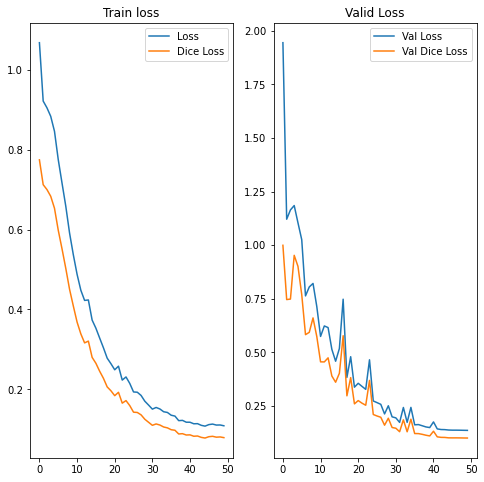

In [49]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [50]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)
    
mean = np.array(mean)
mean = np.mean(mean)
print(f"mean_iou: {mean}")

mean_iou: 0.8831964624340273


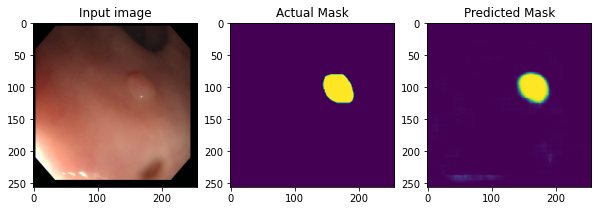

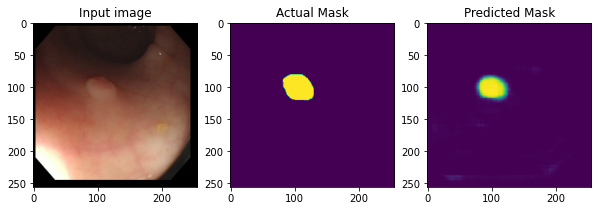

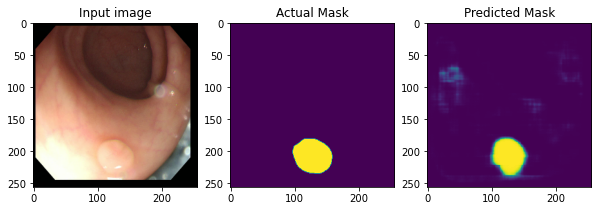

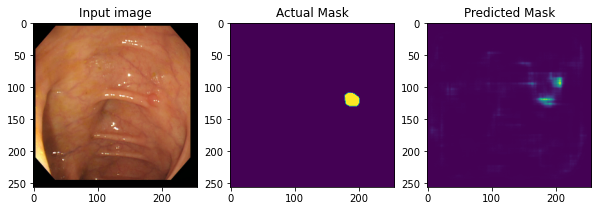

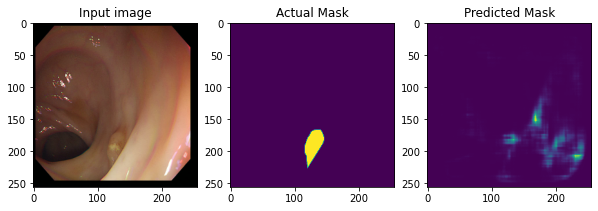

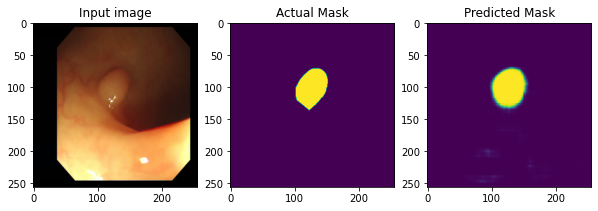

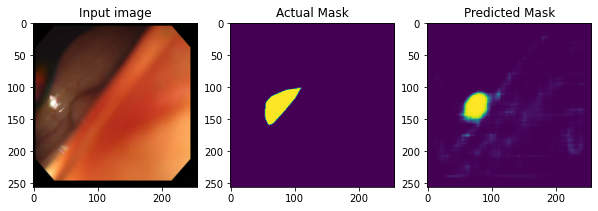

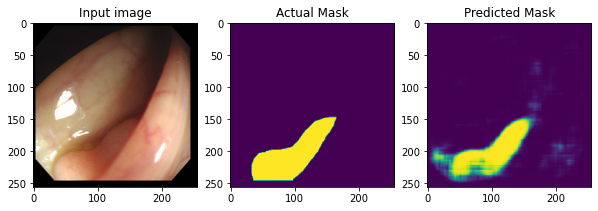

In [51]:
print_images()

##### 4.2 U-Net

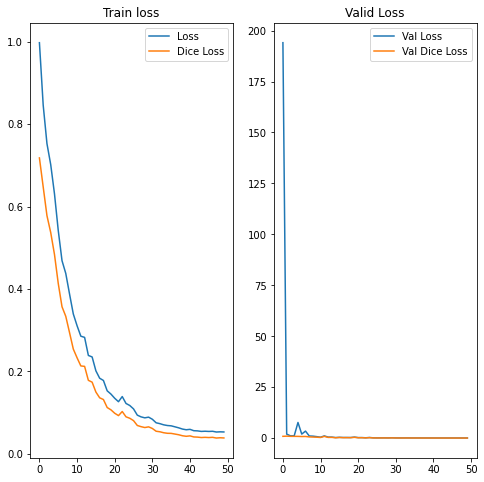

In [38]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [41]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)
    
mean = np.array(mean)
mean = np.mean(mean)
print(f"mean_iou: {mean}")

mean_iou: 0.9353248108496162


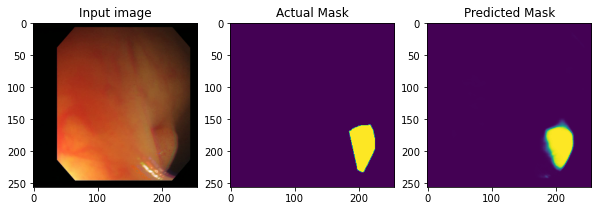

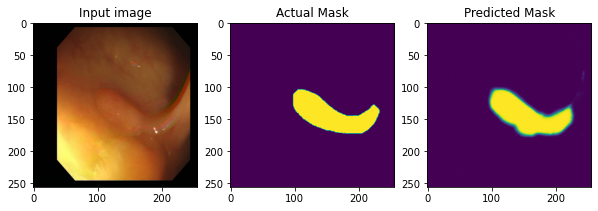

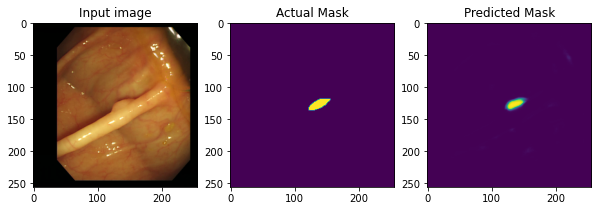

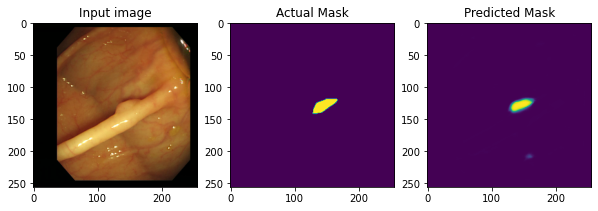

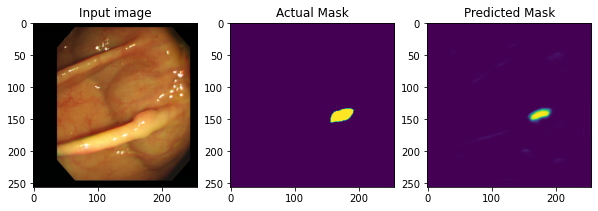

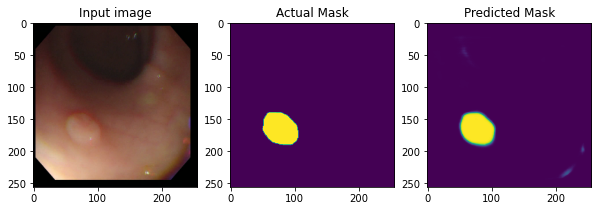

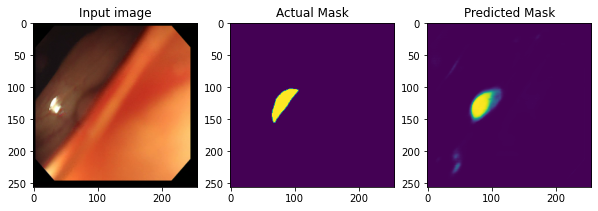

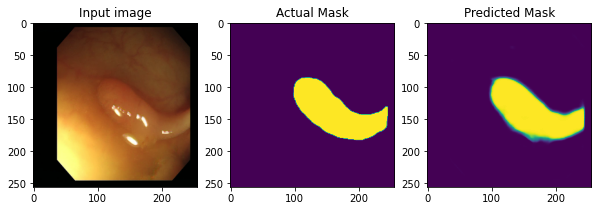

In [42]:
print_images()

##### 4.3 VGG16 Pretrained Model

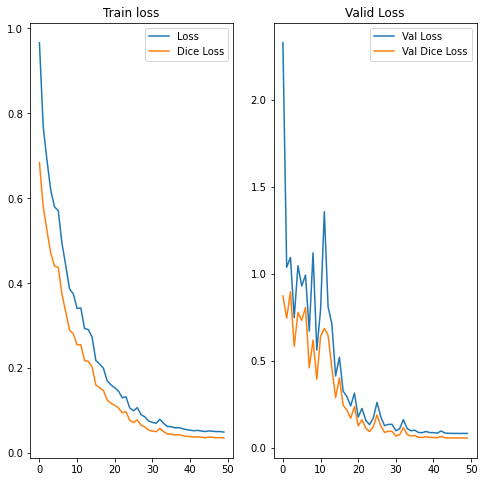

In [39]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [40]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)
    
mean = np.array(mean)
mean = np.mean(mean)
print(f"mean_iou: {mean}")

mean_iou: 0.9272971643086688


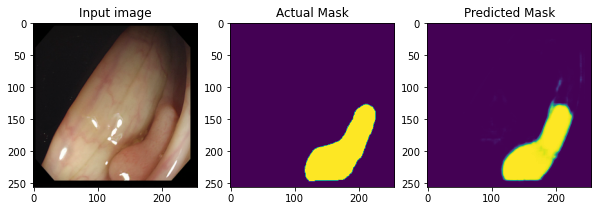

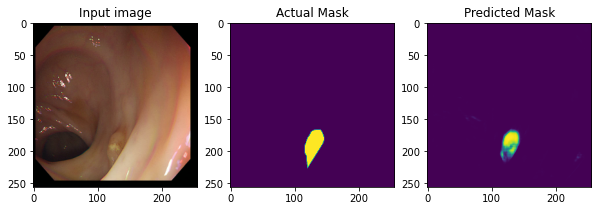

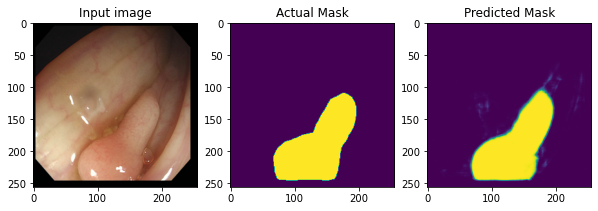

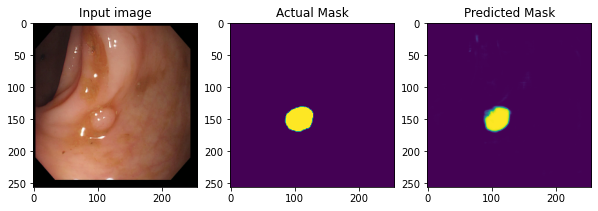

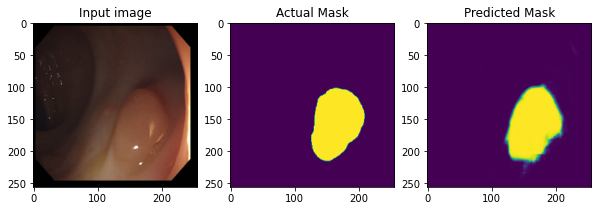

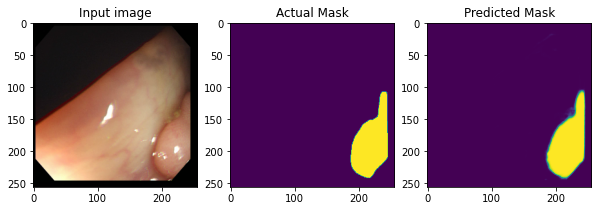

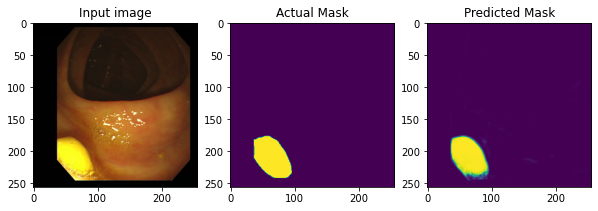

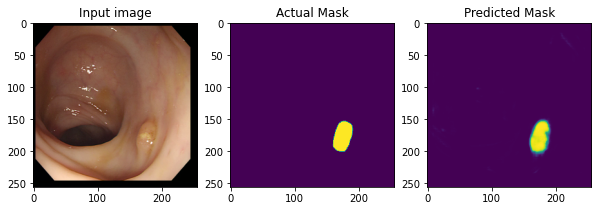

In [41]:
print_images()

- 단순한 Encoder-Decoder보다는 U-Net의 IoU가 더 높게 나오는 것으로 보아 성능이 향상되는 것을 알 수 있었다. 
- pretraine된 모델이 더 좋은 성능을 낼 것이라고 기대하였지만 오히려 U-Net이 조금 더 좋은 결과를 보여 주었다. 의료용 데이터는 Pretrain에 사용된 ImageNet 데이터와는 다른 특성들이 있어 오히려 성능이 더 좋지 않은 것으로 생각이 된다. 

##### 5. 고찰
- 단순한 모델로도 생각보다 용종을 잘 찾아내는 것을 확인할 수 있었고 의료 영역분야에서 많은 활용이 가능할 것이라고 생각된다. 
- VGG16 모델을 불러와 U-Net을 구현할때 layer 하나를 빼먹어 오랫동안 문제를 찾기 위해서 고생을 하였는데 모델을 구현함에 있어서 데이터의 사이즈와 흐름을 제대로 이해하면서 이를 따라가며 모델을 구현하는 것이 도움이 될 것이라는 것을 배울 수 있었다. 
- 이 프로젝트를 통해 Pretrain된 모델이 항상 더 좋은 성능을 내는 것이 아니라는 것을 알 수 있었고 데이터에 따라 오히려 처음부터 모델을 학습시키는 것이 좋은 방법이라는 것을 알 수 있었다.